# 3. Special functions
https://docs.scipy.org/doc/scipy/reference/tutorial/index.html  
https://docs.scipy.org/doc/scipy/reference/tutorial/special.html

In [10]:
%pylab inline
import scipy

Populating the interactive namespace from numpy and matplotlib


The main feature of the scipy.special package is the definition of numerous special functions of mathematical physics. Available functions include airy, elliptic, bessel, gamma, beta, hypergeometric, parabolic cylinder, mathieu, spheroidal wave, struve, and kelvin. There are also some low-level stats functions that are not intended for general use as an easier interface to these functions is provided by the stats module. Most of these functions can take array arguments and return array results following the same broadcasting rules as other math functions in Numerical Python. Many of these functions also accept complex numbers as input. For a complete list of the available functions with a one-line description type >>> ***help(special)***. Each function also has its own documentation accessible using help. If you don’t see a function you need, consider writing it and contributing it to the library. You can write the function in either C, Fortran, or Python. Look in the source code of the library for examples of each of these kinds of functions.

In [4]:
import scipy
from scipy import special

In [5]:
help(special)

Help on package scipy.special in scipy:

NAME
    scipy.special

DESCRIPTION
    Special functions (:mod:`scipy.special`)
    
    .. module:: scipy.special
    
    Nearly all of the functions below are universal functions and follow
    broadcasting and automatic array-looping rules. Exceptions are noted.
    
    Error handling
    
    Errors are handled by returning nans, or other appropriate values.
    Some of the special function routines will emit warnings when an error
    occurs.  By default this is disabled.  To enable such messages use
    ``errprint(1)``, and to disable such messages use ``errprint(0)``.
    
    Example:
    
        >>> print scipy.special.bdtr(-1,10,0.3)
        >>> scipy.special.errprint(1)
        >>> print scipy.special.bdtr(-1,10,0.3)
    
    .. autosummary::
       :toctree: generated/
    
       errprint
       SpecialFunctionWarning -- Warning that can be issued with ``errprint(True)``
    
    Available functions
    
    Airy functions
    -

### Bessel functions of real order(jn, jn_zeros)
Bessel functions are a family of solutions to Bessel’s differential equation with real or complex order alpha:  
> $x^2\frac{d^2 y}{dx^2} + x\frac{dy}{dx} + (x^2 - a^2)y = 0$   

Among other uses, these functions arise in wave propagation problems such as the vibrational modes of a thin drum head. Here is an example of a circular drum head anchored at the edge:

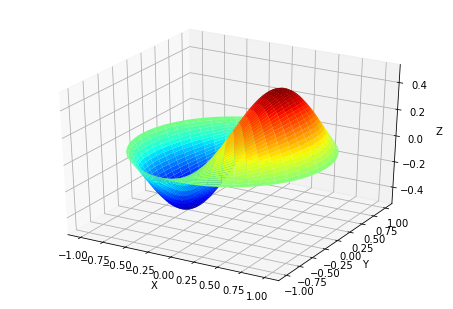

In [8]:
from scipy import special

def drumhead_height(n, k, distance, angle, t):
    kth_zero = special.jn_zeros(n, k)[-1]  # special.jn_zeros
    return np.cos(t) * np.cos(n*angle) * special.jn(n, distance*kth_zero)  # special.jn

theta = np.r_[0:2*np.pi:50j]
radius = np.r_[0:1:50j]
x = np.array([r * np.cos(theta) for r in radius])
y = np.array([r * np.sin(theta) for r in radius])
z = np.array([drumhead_height(1, 1, r, theta, 0.5) for r in radius])


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)

ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.jet)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Cython Bindings for Special Functions (scipy.special.cython_special)
Scipy also offers Cython bindings for scalar, typed versions of many of the functions in special. The following Cython code gives a simple example of how to use these functions:
```
cimport scipy.special.cython_special as csc

cdef:
    double x = 1
    double complex z = 1 + 1j
    double si, ci, rgam
    double complex cgam

rgam = csc.gamma(x)
print(rgam)
cgam = csc.gamma(z)
print(cgam)
csc.sici(x, &si, &ci)
print(si, ci)
```

(See the Cython documentation for help with compiling Cython.) In the example the function csc.gamma works essentially like its ufunc counterpart gamma, though it takes C types as arguments instead of NumPy arrays. Note in particular that the function is overloaded to support real and complex arguments; the correct variant is selected at compile time. The function csc.sici works slightly differently from sici; for the ufunc we could write ai, bi = sici(x) whereas in the Cython version multiple return values are passed as pointers. It might help to think of this as analogous to calling a ufunc with an output array: sici(x, out=(si, ci)).

There are two potential advantages to using the Cython bindings:

- They avoid Python function overhead
- They do not require the Python Global Interpreter Lock (GIL)  

The following sections discuss how to use these advantages to potentially speed up your code, though of course one should always profile the code first to make sure putting in the extra effort will be worth it.

### Avoiding Python Function Overhead

For the ufuncs in special, Python function overhead is avoided by vectorizing, that is, by passing an array to the function. Typically this approach works quite well, but sometimes it is more convenient to call a special function on scalar inputs inside a loop, for example when implementing your own ufunc. In this case the Python function overhead can become significant. Consider the following example:
```
import scipy.special as sc
cimport scipy.special.cython_special as csc

def python_tight_loop():
    cdef:
        int n
        double x = 1

    for n in range(100):
        sc.jv(n, x)

def cython_tight_loop():
    cdef:
        int n
        double x = 1

    for n in range(100):
        csc.jv(n, x)
```        
On one computer python_tight_loop took about 131 microseconds to run and cython_tight_loop took about 18.2 microseconds to run. Obviously this example is contrived: one could just call special.jv(np.arange(100), 1) and get results just as fast as in cython_tight_loop. The point is that if Python function overhead becomes significant in your code then the Cython bindings might be useful.

### Releasing the GIL

One often needs to evaluate a special function at many points, and typically the evaluations are trivially parallelizable. Since the Cython bindings do not require the GIL, it is easy to run them in parallel using Cython’s prange function. For example, suppose that we wanted to compute the fundamental solution to the Helmholtz equation:
```
ΔxG(x,y)+k2G(x,y)=δ(x−y), 
```
where kk is the wavenumber and δδ is the Dirac delta function. It is known that in two dimensions the unique (radiating) solution is
```
G(x,y)=i4H(1)0(k|x−y|), 
```
where H(1)0H0(1) is the Hankel function of the first kind, i.e. the function hankel1. The following example shows how we could compute this function in parallel:
```
from libc.math cimport fabs
cimport cython
from cython.parallel cimport prange

import numpy as np
import scipy.special as sc
cimport scipy.special.cython_special as csc

def serial_G(k, x, y):
    return 0.25j*sc.hankel1(0, k*np.abs(x - y))

@cython.boundscheck(False)
@cython.wraparound(False)
cdef void _parallel_G(double k, double[:,:] x, double[:,:] y,
                      double complex[:,:] out) nogil:
    cdef int i, j

    for i in prange(x.shape[0]):
        for j in range(y.shape[0]):
            out[i,j] = 0.25j*csc.hankel1(0, k*fabs(x[i,j] - y[i,j]))

def parallel_G(k, x, y):
    out = np.empty_like(x, dtype='complex128')
    _parallel_G(k, x, y, out)
    return out
```    
(For help with compiling parallel code in Cython see here.) If the above Cython code is in a file test.pyx, then we can write an informal benchmark which compares the parallel and serial versions of the function:
```
import timeit

import numpy as np

from test import serial_G, parallel_G

def main():
    k = 1
    x, y = np.linspace(-100, 100, 1000), np.linspace(-100, 100, 1000)
    x, y = np.meshgrid(x, y)

    def serial():
        serial_G(k, x, y)

    def parallel():
        parallel_G(k, x, y)

    time_serial = timeit.timeit(serial, number=3)
    time_parallel = timeit.timeit(parallel, number=3)
    print("Serial method took {:.3} seconds".format(time_serial))
    print("Parallel method took {:.3} seconds".format(time_parallel))

if __name__ == "__main__":
    main()
```    
On one quad-core computer the serial method took 1.29 seconds and the parallel method took 0.29 seconds.

### Functions not in scipy.special
Some functions are not included in special because they are straightforward to implement with existing functions in NumPy and SciPy. To prevent reinventing the wheel, this section provides implementations of several such functions which hopefully illustrate how to handle similar functions. In all examples NumPy is imported as np and special is imported as sc.

The binary entropy function:
```
def binary_entropy(x):
    return -(sc.xlogy(x, x) + sc.xlog1py(1 - x, -x))/np.log(2)
```    
The Heaviside step function:
```
def heaviside(x):
    return 0.5*(np.sign(x) + 1)
```    
A similar idea can also be used to get a step function on [0, 1]:
```
def step(x):
    return 0.5*(np.sign(x) + np.sign(1 - x))
```    
Translating and scaling can be used to get an arbitrary step function.

The ramp function:
```
def ramp(x):
    return np.maximum(0, x)
```    